<a href="https://colab.research.google.com/github/msabbirsalek/DL-with-PyTorch/blob/main/hw_1_2_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

**Load CIFAR10 Dataset**

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['bird', 'airplane', 'dog', 'automobile', 'cat', 'deer', 'ship', 'frog', 'truck', 'horse']


In [4]:
automobile_images = os.listdir(data_dir + "/train/automobile")
print('No. of training examples for automobiles:', len(automobile_images))
print(automobile_images[:5])

No. of training examples for automobiles: 5000
['0434.png', '0230.png', '4475.png', '1200.png', '3790.png']


In [5]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
print('Length of the dataset:', len(dataset))

Length of the dataset: 50000


In [6]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


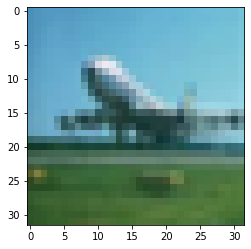

In [8]:
show_image(*dataset[100])

Label:  airplane (0)


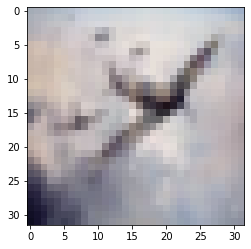

In [9]:
show_image(*dataset[50])

**Preapre datasets for trainning and validation**

In [10]:
# Set a random seed to always use the same trainning subset
random_seed = 51
torch.manual_seed(random_seed);

In [11]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [12]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
def show_imagebatch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


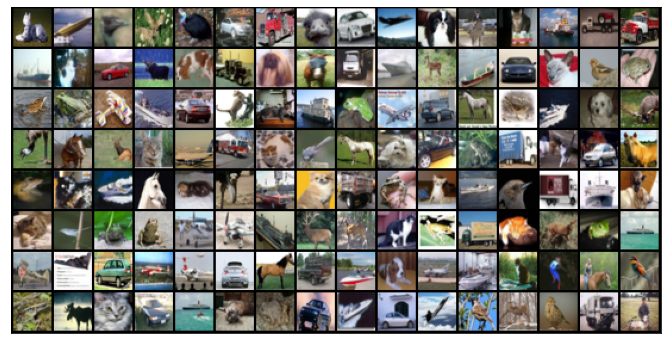

In [14]:
show_imagebatch(train_dl)

**Define CNN**

In [15]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [50]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

**Model0**

In [51]:
class Cifar10CnnModel0(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #Conv Layer3: channels 64 to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 128 to 128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            #Conv Layer5: channels 128 to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 256 to 256
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            #Linear Layer1: 256*4*4 to 1024
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            #Linear Layer2: 1024 to 512
            nn.Linear(1024, 512),
            nn.ReLU(),
            #Linear Layer3: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [52]:
model0 = Cifar10CnnModel0()
model0

Cifar10CnnModel0(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [53]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [54]:
count_parameters(model0)

5851338

**Use GPU for trainning**

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [55]:
device = get_default_device()
device

device(type='cuda')

**Place dataloaders and the model into GPU**

In [56]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model0, device);

**Model Trainning Phase**

In [57]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [58]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [59]:
#Sanity checking
evaluate(model0, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09486442804336548, 'val_loss': 2.3034751415252686}

In [60]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

In [61]:
#Start tranning
history0 = fit(num_epochs, lr, model0, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7250, train_acc: 0.3535, val_loss: 1.4339, val_acc: 0.4742
Epoch [1], train_loss: 1.1874, train_acc: 0.5707, val_loss: 1.0701, val_acc: 0.6192
Epoch [2], train_loss: 0.9341, train_acc: 0.6675, val_loss: 0.8577, val_acc: 0.6986
Epoch [3], train_loss: 0.7576, train_acc: 0.7328, val_loss: 0.8039, val_acc: 0.7185
Epoch [4], train_loss: 0.6183, train_acc: 0.7831, val_loss: 0.7008, val_acc: 0.7578
Epoch [5], train_loss: 0.5156, train_acc: 0.8195, val_loss: 0.6840, val_acc: 0.7728
Epoch [6], train_loss: 0.4035, train_acc: 0.8568, val_loss: 0.7257, val_acc: 0.7672
Epoch [7], train_loss: 0.3067, train_acc: 0.8898, val_loss: 0.7363, val_acc: 0.7572
Epoch [8], train_loss: 0.2307, train_acc: 0.9168, val_loss: 0.7931, val_acc: 0.7754
Epoch [9], train_loss: 0.1761, train_acc: 0.9378, val_loss: 0.8959, val_acc: 0.7560
Epoch [10], train_loss: 0.1437, train_acc: 0.9495, val_loss: 1.0134, val_acc: 0.7614
Epoch [11], train_loss: 0.1208, train_acc: 0.9586, val_loss: 1.0544, val_ac

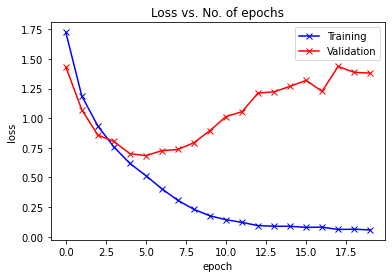

In [62]:
plot_losses(history0)

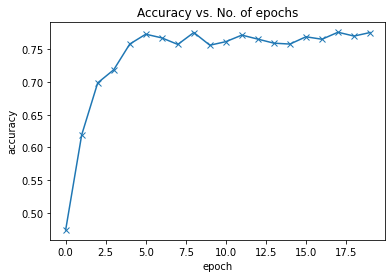

In [63]:
plot_accuracies(history0)

In [64]:
train_losses0 = [x['train_loss'] for x in history0]
train_accuracies0 = [x['train_acc'] for x in history0]
val_accuracies0 = [x['val_acc'] for x in history0]

**Save the trained model, trainning losses and accuracies**

In [65]:
torch.save(model0.state_dict(), 'HW_1_2_CIFAR10_model0.pth')
pd.DataFrame(train_losses0).to_csv('HW_1_2_CIFAR10_model0_train_losses.csv',index=False)
pd.DataFrame(train_accuracies0).to_csv('HW_1_2_CIFAR10_model0_train_accuracies.csv',index=False)
pd.DataFrame(val_accuracies0).to_csv('HW_1_2_CIFAR10_model0_val_accuracies.csv',index=False)

**Model1**

In [88]:
class Cifar10CnnModel1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #Conv Layer3: channels 64 to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 128 to 128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            #Conv Layer5: channels 128 to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 256 to 256
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            #Conv Layer7: channels 256 to 512
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer8: channels 512 to 512
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 2 x 2

            nn.Flatten(), 
            #Linear Layer1: 512*2*2 to 1024
            nn.Linear(512*2*2, 1024),
            nn.ReLU(),
            #Linear Layer2: 1024 to 512
            nn.Linear(1024, 512),
            nn.ReLU(),
            #Linear Layer3: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [89]:
model1 = Cifar10CnnModel1()
model1

Cifar10CnnModel1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride

In [90]:
count_parameters(model1)

7294154

In [91]:
to_device(model1, device);

In [92]:
#Sanity checking
evaluate(model1, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.0943818911910057, 'val_loss': 2.3027889728546143}

In [93]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

In [94]:
#Start tranning
history1 = fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.8745, train_acc: 0.2608, val_loss: 1.6225, val_acc: 0.3641
Epoch [1], train_loss: 1.4558, train_acc: 0.4371, val_loss: 1.2968, val_acc: 0.5221
Epoch [2], train_loss: 1.1506, train_acc: 0.5746, val_loss: 1.0455, val_acc: 0.6194
Epoch [3], train_loss: 0.9504, train_acc: 0.6549, val_loss: 0.9047, val_acc: 0.6763
Epoch [4], train_loss: 0.8087, train_acc: 0.7106, val_loss: 0.8699, val_acc: 0.6967
Epoch [5], train_loss: 0.6958, train_acc: 0.7545, val_loss: 0.8144, val_acc: 0.7258
Epoch [6], train_loss: 0.5977, train_acc: 0.7883, val_loss: 0.7203, val_acc: 0.7557
Epoch [7], train_loss: 0.5055, train_acc: 0.8232, val_loss: 0.7166, val_acc: 0.7668
Epoch [8], train_loss: 0.4303, train_acc: 0.8469, val_loss: 0.7308, val_acc: 0.7592
Epoch [9], train_loss: 0.3731, train_acc: 0.8692, val_loss: 0.7494, val_acc: 0.7612
Epoch [10], train_loss: 0.3146, train_acc: 0.8893, val_loss: 0.8398, val_acc: 0.7420
Epoch [11], train_loss: 0.2779, train_acc: 0.9010, val_loss: 0.8794, val_ac

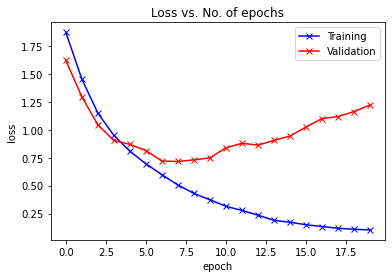

In [95]:
plot_losses(history1)

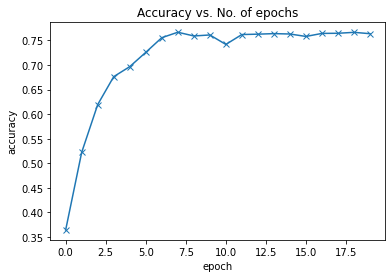

In [96]:
plot_accuracies(history1)

In [97]:
train_losses1 = [x['train_loss'] for x in history1]
train_accuracies1 = [x['train_acc'] for x in history1]
val_accuracies1 = [x['val_acc'] for x in history1]

**Save the trained model, trainning losses and accuracies**

In [107]:
torch.save(model1.state_dict(), 'HW_1_2_CIFAR10_model1.pth')
pd.DataFrame(train_losses1).to_csv('HW_1_2_CIFAR10_model1_train_losses.csv',index=False)
pd.DataFrame(train_accuracies1).to_csv('HW_1_2_CIFAR10_model1_train_accuracies.csv',index=False)
pd.DataFrame(val_accuracies1).to_csv('HW_1_2_CIFAR10_model1_val_accuracies.csv',index=False)

**Model2**

In [108]:
class Cifar10CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #Conv Layer3: channels 64 to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 128 to 128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            #Conv Layer5: channels 128 to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 256 to 256
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            #Conv Layer7: channels 256 to 512
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer8: channels 512 to 512
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 2 x 2

            nn.Flatten(), 
            #Linear Layer1: 512*2*2 to 1024
            nn.Linear(512*2*2, 1024),
            nn.ReLU(),
            #Linear Layer2: 1024 to 512
            nn.Linear(1024, 512),
            nn.ReLU(),
            #Linear Layer3: 512 to 256
            nn.Linear(512, 256),
            nn.ReLU(),
            #Linear Layer4: 256 to 10
            nn.Linear(256, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [109]:
model2 = Cifar10CnnModel2()
model2

Cifar10CnnModel2(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride

In [110]:
count_parameters(model2)

7422922

In [111]:
to_device(model2, device);

In [112]:
#Sanity checking
evaluate(model2, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.10004595667123795, 'val_loss': 2.3029868602752686}

In [113]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

In [114]:
#Start tranning
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.0262, train_acc: 0.2194, val_loss: 1.7876, val_acc: 0.3226
Epoch [1], train_loss: 1.5877, train_acc: 0.4034, val_loss: 1.4223, val_acc: 0.4687
Epoch [2], train_loss: 1.3052, train_acc: 0.5189, val_loss: 1.1967, val_acc: 0.5696
Epoch [3], train_loss: 1.0834, train_acc: 0.6081, val_loss: 1.0741, val_acc: 0.6151
Epoch [4], train_loss: 0.9332, train_acc: 0.6650, val_loss: 0.9603, val_acc: 0.6530
Epoch [5], train_loss: 0.8299, train_acc: 0.7046, val_loss: 0.9039, val_acc: 0.6796
Epoch [6], train_loss: 0.7243, train_acc: 0.7446, val_loss: 0.8670, val_acc: 0.6908
Epoch [7], train_loss: 0.6398, train_acc: 0.7725, val_loss: 0.7915, val_acc: 0.7271
Epoch [8], train_loss: 0.5631, train_acc: 0.7998, val_loss: 0.7817, val_acc: 0.7373
Epoch [9], train_loss: 0.4927, train_acc: 0.8273, val_loss: 0.7954, val_acc: 0.7393
Epoch [10], train_loss: 0.4190, train_acc: 0.8523, val_loss: 0.8635, val_acc: 0.7298
Epoch [11], train_loss: 0.3638, train_acc: 0.8712, val_loss: 0.8786, val_ac

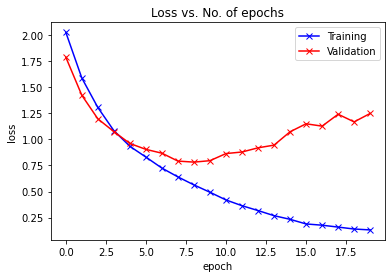

In [115]:
plot_losses(history2)

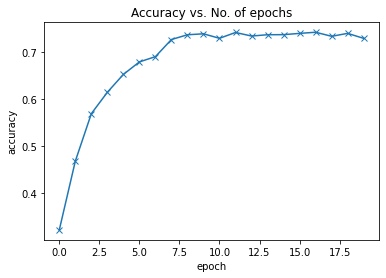

In [116]:
plot_accuracies(history2)

In [117]:
train_losses2 = [x['train_loss'] for x in history2]
train_accuracies2 = [x['train_acc'] for x in history2]
val_accuracies2 = [x['val_acc'] for x in history2]

**Save the trained model, trainning losses and accuracies**

In [118]:
torch.save(model2.state_dict(), 'HW_1_2_CIFAR10_model2.pth')
pd.DataFrame(train_losses2).to_csv('HW_1_2_CIFAR10_model2_train_losses.csv',index=False)
pd.DataFrame(train_accuracies2).to_csv('HW_1_2_CIFAR10_model2_train_accuracies.csv',index=False)
pd.DataFrame(val_accuracies2).to_csv('HW_1_2_CIFAR10_model2_val_accuracies.csv',index=False)

In [136]:
def plot_all_model_accuracies(history0,history1,history2):
    train_accuracies0 = [x['train_acc'] for x in history0]
    train_accuracies1 = [x['train_acc'] for x in history1]
    train_accuracies2 = [x['train_acc'] for x in history2]
    val_accuracies0 = [x['val_acc'] for x in history0]
    val_accuracies1 = [x['val_acc'] for x in history1]
    val_accuracies2 = [x['val_acc'] for x in history2]
    plt.plot(train_accuracies0, '-x', label="Train_Accuracy_CNN_Model_0")
    plt.plot(val_accuracies0, '-x', label="Test_Accuracy_CNN_Model_0")
    plt.plot(train_accuracies1, '-x', label="Train_Accuracy_CNN_Model_1")
    plt.plot(val_accuracies1, '-x', label="Test_Accuracy_CNN_Model_1")
    plt.plot(train_accuracies2, '-x', label="Train_Accuracy_CNN_Model_2")
    plt.plot(val_accuracies2, '-x', label="Test_Accuracy_CNN_Model_2")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.title('Accuracy vs. No. of epochs');
    
def plot_all_model_losses(history0,history1,history2):
    train_losses0 = [x.get('train_loss') for x in history0]
    train_losses1 = [x.get('train_loss') for x in history1]
    train_losses2 = [x.get('train_loss') for x in history2]
    plt.plot(train_losses0, '-x', label="CNN_Model_0")
    plt.plot(train_losses1, '-x', label="CNN_Model_1")
    plt.plot(train_losses2, '-x', label="CNN_Model_2")
    plt.xlabel('Epoch')
    plt.xlim([-1, 20])
    plt.ylabel('Trainning loss')
    plt.legend(loc="upper right")
    plt.title('Loss vs. No. of epochs');

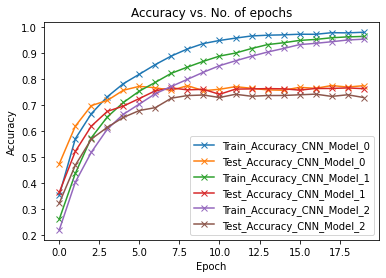

In [137]:
plot_all_model_accuracies(history0,history1,history2)

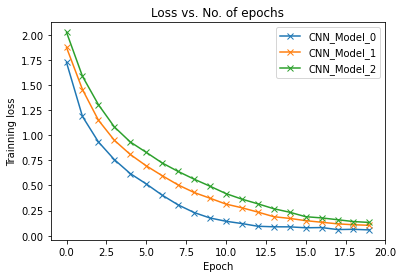

In [138]:
plot_all_model_losses(history0,history1,history2)